# Class 3 - Regularization and cross-validation

**Packages import**

In [1]:
%%capture
!pip install tqdm pandas numpy matplotlib seaborn scikit-learn

In [5]:
from functools import partial

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
tqdm = partial(tqdm, position=0, leave=True)

In [8]:
plt.style.use('bmh')

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC

## Dataset - preparation and One-Hot Encoding

In [10]:
#Titanic dataset - information about passangers with indication of survival
#Task: binary classification of target column Survived
dataset = pd.read_csv(
    "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv",
    sep=',',
    header=0)

**Dataset exploration**

In [11]:
dataset.isna().sum()

Survived                   0
Pclass                     0
Name                       0
Sex                        0
Age                        0
Siblings/Spouses Aboard    0
Parents/Children Aboard    0
Fare                       0
dtype: int64

In [12]:
dataset.describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
count,887.000000,887.000000,887.000000,887.000000,887.000000,887.00000
mean,0.385569,2.305524,29.471443,0.525366,0.383315,32.30542
std,0.487004,0.836662,14.121908,1.104669,0.807466,49.78204
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.00000
25%,0.000000,2.000000,20.250000,0.000000,0.000000,7.92500
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.45420
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.13750
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.32920


In [13]:
dataset.describe(include=['O'])

,Name,Sex
count,887,887
unique,887,2
top,Mr. Owen Harris Braund,male
freq,1,573


In [14]:
dataset['Siblings/Spouses Aboard'].value_counts().sort_index()

0    604
1    209
2     28
3     16
4     18
5      5
8      7
Name: Siblings/Spouses Aboard, dtype: int64

In [15]:
dataset['Parents/Children Aboard'].value_counts().sort_index()

0    674
1    118
2     80
3      5
4      4
5      5
6      1
Name: Parents/Children Aboard, dtype: int64

In [16]:
dataset.Pclass.value_counts()

3    487
1    216
2    184
Name: Pclass, dtype: int64

In [17]:
dataset.Survived.value_counts() / dataset.shape[0]

0    0.614431
1    0.385569
Name: Survived, dtype: float64

**Dataset preprocessing**

In [18]:
dataset.drop(columns='Name', inplace=True)

In [19]:
dataset.Pclass = dataset.Pclass.astype(str)

In [22]:
dataset

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
882,0,2,male,27.0,0,0,13.0000
883,1,1,female,19.0,0,0,30.0000
884,0,3,female,7.0,1,2,23.4500
885,1,1,male,26.0,0,0,30.0000


In [23]:
ohe = OneHotEncoder(sparse=False)
# ohe.fit(dataset.select_dtypes('O'))
ohe_data = ohe.fit_transform(dataset.select_dtypes('O'))
ohe_df = pd.DataFrame(data=ohe_data, columns=ohe.get_feature_names())

In [24]:
dataset = pd.concat([dataset.select_dtypes(exclude='O'), ohe_df], axis=1)

In [25]:
X = dataset.drop(columns='Survived')
y = dataset.Survived
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.6,
                                                    random_state=42)

## Regularization

**Regularization** techniques are modifications introduced in models aimed at **reducing overfitting**. The modification usually involves putting constraints on the coefficient's estimate or altering the training process with additional steps. Good regularization technique will decrease **variance** significantly, while not increasing **bias** or increasing it slightly.

Examples of regularization techniques are:
- L1 regularization (e.g. lasso regression)
- L2 regualrization (e.g. ridge regression)
- Elasticnet
- cost/complexity pruning for decision trees
- cost parameter for support vector machines
- dropout for neural networks
- early stopping


L1:$$min\frac{1}{n}||Xw-y||^2+\lambda||w||_1 \quad \left(\lambda\sum_i|w_i|\right)$$
L2:$$min\frac{1}{n}||Xw-y||^2+\lambda||w||_2^2 \quad \left(\lambda\sum_iw_i^2\right)$$
Elasticnet:
$$min\frac{1}{n}||Xw-y||^2+\lambda\left(\alpha||w||_1+(1-\alpha)||w||_2^2\right) \quad \left(\lambda\left(\alpha\sum_i|w_i|+(1-\alpha)\sum_iw_i^2\right)\right)$$

![](https://upload.wikimedia.org/wikipedia/commons/b/b8/Sparsityl1.png)
![](https://upload.wikimedia.org/wikipedia/commons/f/f7/Sparsityen.png)

Logistic regression without regularization

In [28]:
lr_titanic = LR(penalty='none', max_iter=1000)
lr_titanic.fit(X_train, y_train)
lr_no_reg_auc = roc_auc_score(y_test, lr_titanic.predict_proba(X_test)[:, 1])
print(
    f"AUC for logistic regression with no regularization: {lr_no_reg_auc:.3f}")

AUC for logistic regression with no regularization: 0.815


**Hyperparameter tuning**

Tuning elements:
- metric (F1-score, AUC)
- hyperparameter(s) (cutoff threshold, regularization strength, number of trees)
- technique (grid search, random search, bayesian search)

Task: Find value of regularization strength (C) and type of regularization (L1/L2) that maximizes AUC on validation set

Logistic regression L1 regularization

In [29]:
def model_auc(model, X_train, X_test, y_train, y_test):
    trained_model = model.fit(X_train, y_train)
    return roc_auc_score(y_test, trained_model.predict_proba(X_test)[:, 1])

In [30]:
cs = np.linspace(0.001, 0.2, 100)  # 100 values of C evenly distributed between 0.001 and 0.2

In [31]:
LR_L1 = partial(LR, penalty='l1', max_iter=1000, solver='liblinear')
aucs_l1 = [
    model_auc(LR_L1(C=c), X_train, X_test, y_train, y_test) for c in tqdm(cs)
]

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 177.86it/s]


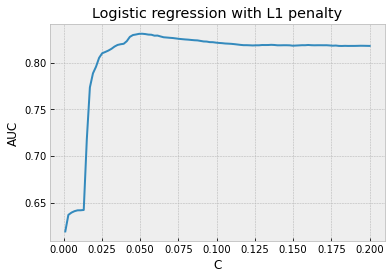

In [32]:
p = sns.lineplot(x=cs, y=aucs_l1)
p.set_xlabel("C")
p.set_ylabel("AUC")
p.set_title("Logistic regression with L1 penalty");

In [33]:
def lr_l1_coeffs_for_c(c):
    return dict(zip(X_train.columns,
                    LR_L1(C=c).fit(X_train, y_train).coef_[0]))

In [34]:
lr_l1_coeffs_for_c(0.01)

{'Age': -0.026380026802100512,
 'Siblings/Spouses Aboard': 0.0,
 'Parents/Children Aboard': 0.0,
 'Fare': 0.011384048738524232,
 'x0_1': 0.0,
 'x0_2': 0.0,
 'x0_3': 0.0,
 'x1_female': 0.0,
 'x1_male': 0.0}

In [35]:
lr_l1_coeffs_for_c(0.02)

{'Age': -0.01429469760212848,
 'Siblings/Spouses Aboard': 0.0,
 'Parents/Children Aboard': 0.0,
 'Fare': 0.010766176975253039,
 'x0_1': 0.0,
 'x0_2': 0.0,
 'x0_3': 0.0,
 'x1_female': 0.0,
 'x1_male': -0.6694528605489316}

**Important note:** L1 penalty prevents overfitting but also serves as **feature selection** method

Logistic regression L2 regularization

In [36]:
aucs_l2 = [
    model_auc(LR(C=c, max_iter=1000), X_train, X_test, y_train, y_test)
    for c in tqdm(cs)
]

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 29.76it/s]


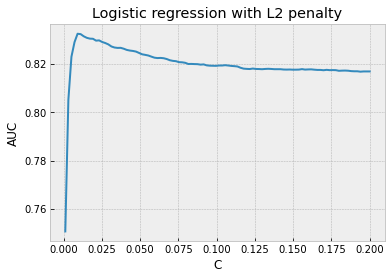

In [37]:
p = sns.lineplot(x=cs, y=aucs_l2)
p.set_xlabel("C")
p.set_ylabel("AUC")
p.set_title("Logistic regression with L2 penalty");

Support Vector Classifier

In [38]:
cs_svc = np.linspace(0.01, 300, 100)
aucs_svc = [
    model_auc(SVC(C=c, probability=True), X_train, X_test, y_train, y_test)
    for c in tqdm(cs_svc)
]

100%|█████████████████████████████████████████| 100/100 [00:12<00:00,  8.14it/s]


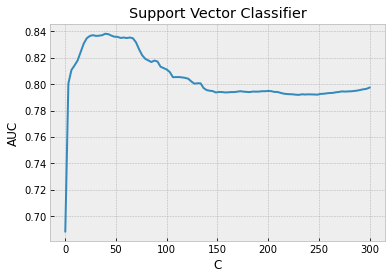

In [39]:
p = sns.lineplot(x=cs_svc, y=aucs_svc)
p.set_xlabel("C")
p.set_ylabel("AUC")
p.set_title("Support Vector Classifier");

**Summary for all models**

In [40]:
print(f"""Logistic regression (no penalty): {lr_no_reg_auc:.4f} AUC
Logistic regression (L1): {max(aucs_l1):.4f} AUC for C={cs[np.argmax(aucs_l1)]:.4f}
Logistic regression (L2): {max(aucs_l2):.4f} AUC for C={cs[np.argmax(aucs_l2)]:.4f}
SVC: {max(aucs_svc):.4f} AUC for C={cs_svc[np.argmax(aucs_svc)]:.4f}""")

Logistic regression (no penalty): 0.8145 AUC
Logistic regression (L1): 0.8308 AUC for C=0.0513
Logistic regression (L2): 0.8325 AUC for C=0.0090
SVC: 0.8382 AUC for C=39.4026


In [41]:
round(roc_auc_score(y_train, lr_titanic.predict_proba(X_train)[:, 1]), 4)

0.8777

## Cross-validation

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=75%>

Advantages:
- reduces estimation error connected with random split of dataset
- provides robust scores in case of overfitted model
- no need to split data into training and validation subsets explicitly

Disadvantages:
- expensive computationally (training _k_ models instead of 1)
- introduces another hyperparameter (_k_)
- more complex training and evaluation pipeline

More information on [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) page in scikit-learn documentation.

In [42]:
def auc_scorer(model, X, y):
    return roc_auc_score(y, model.predict_proba(X)[:, 1])

In [46]:
folds = 3
scores = cross_val_score(LR(max_iter=1000, random_state=42), X, y, cv=folds, scoring=auc_scorer) #scoring='roc_auc'
print(scores)
print(f"Mean AUC score: {np.mean(scores):.3f}")

[0.83624928 0.85273279 0.85846176]
Mean AUC score: 0.849


In [47]:
aucs_mean = np.array([])
aucs_std = np.array([])
cs_svc_xval = range(1,101)
for c in tqdm(cs_svc_xval):
    xval_arr = cross_val_score(SVC(C=c, probability=True, random_state=42),
                               X,
                               y,
                               cv=folds,
                               scoring=auc_scorer)
    aucs_mean = np.append(aucs_mean, np.mean(xval_arr))
    aucs_std = np.append(aucs_std, np.std(xval_arr))

100%|█████████████████████████████████████████| 100/100 [00:37<00:00,  2.66it/s]


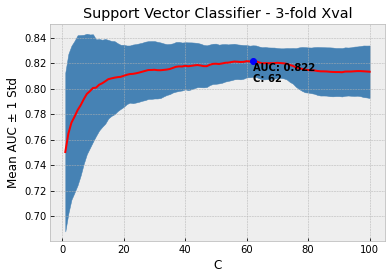

In [45]:
plt.plot(cs_svc_xval, aucs_mean, 'r')
plt.fill_between(cs_svc_xval,
                 aucs_mean - aucs_std,
                 aucs_mean + aucs_std,
                 color='steelblue')
best_c = cs_svc_xval[np.argmax(aucs_mean)]
best_mean_auc = np.max(aucs_mean)
plt.plot(best_c, best_mean_auc, 'bo')
plt.annotate(f'AUC: {best_mean_auc:.3f} \nC: {best_c}',
             (best_c, best_mean_auc * 0.98),
             weight='bold')
plt.xlabel("C")
plt.ylabel("Mean AUC ± 1 Std")
plt.title(f"Support Vector Classifier - {folds}-fold Xval");

Grid search hyperparameter tuning + cross-validation = [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

### Exercices

Write your own "scorer" function returning F1-score (with 0.5 cutoff threshold)

Perform hyperparameter tuning for logistic regression with **elasticnet** regularization. Tune value of **L1 ratio** hyperparameter. Use prepared data for Titanic dataset (`X` and `y` Dataframes).

Tuning specification:
- set regularization strength argument to 0.1
- perform grid search of 50 evenly distributed values on whole range of L1 ratio
- use F1-score as target metrics
- use 3-fold cross-validation to estimate the metric

Plot the results on lineplot with L1 ratio on x-axis and mean F1 on y-axis. What is the optimal value of L1 ratio and mean F1-score corresponding to it?